## Imports and Helper Functions

In [1]:
RE_RUN_CELLS = True

import sys
#Path to Trane for imports
sys.path.append('/Users/Alexander/Documents/Trane/Trane__HDI_REPO')
path_to_datasets = '../../../Trane__Local_Misc/Formatted Datasets/Yelp Reviews/'
import pandas as pd
import trane
import json
import random
import datetime
import pickle
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
import scikitplot as skplt

def save_obj(obj, name):
    with open('/pickled_objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    try:
        with open('/pickled_objects/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        return None
def generate_probs(entity_id_column,
                            label_generating_column,
                            time_column,
                            table_meta,
                            filter_column,
                            is_pick_random_problems = True):
    generator = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    probs = []

    all_probs = list(generator.generate())

    if is_pick_random_problems:
        random.shuffle(all_probs)

    for idx, prob in enumerate(all_probs):
        probs.append(prob)
        if idx + 1 == NUM_PROBLEMS_TO_GENERATE:
            break
    prediction_problems_json = trane.prediction_problems_to_json_file(
        probs, table_meta, entity_id_column, label_generating_column, time_column, "prediction_problems.json")

    return probs

def convert(str, format = None):
    return datetime.datetime.strptime(str, format)
def file_to_table_meta(filepath):
    return trane.TableMeta(json.loads(open(filepath).read()))

## Load, Format and Sample Data (2 Minutes)

In [2]:
merged_df = load_obj('merged_df')
sampled_yelp_business_df = load_obj('sampled_yelp_business_df')
sampled_yelp_review_df = load_obj('sampled_yelp_review_df')
sampled_yelp_user_df = load_obj('sampled_yelp_user_df')
sampled_yelp_checkin_df = load_obj('sampled_yelp_checkin_df')

if  (merged_df is None or 
    sampled_yelp_business_df is None or 
    sampled_yelp_review_df is None or 
    sampled_yelp_user_df is None or
    sampled_yelp_checkin_df is None or
    RE_RUN_CELLS):
    
    yelp_review_df = pd.read_csv(path_to_datasets + 'yelp_review.csv')
    yelp_checkin_df = pd.read_csv(path_to_datasets + 'yelp_checkin.csv')
    yelp_business_df = pd.read_csv(path_to_datasets + 'yelp_business.csv')
    yelp_user_df = pd.read_csv(path_to_datasets + 'yelp_user.csv')

    sampled_yelp_review_df = yelp_review_df.head(1000)
    sampled_business_ids = sampled_yelp_review_df['business_id'].unique()
    sampled_user_ids = sampled_yelp_review_df['user_id'].unique()
    sampled_review_ids = sampled_yelp_review_df['review_id'].unique()
    sampled_yelp_checkin_df = yelp_checkin_df[yelp_checkin_df['business_id'].isin(sampled_business_ids)]
    sampled_yelp_business_df = yelp_business_df[yelp_business_df['business_id'].isin(sampled_business_ids)] 
    sampled_yelp_user_df = yelp_user_df[yelp_user_df['user_id'].isin(sampled_user_ids)]

    assert(len(sampled_business_ids) == len(sampled_yelp_business_df))
    assert(len(sampled_user_ids) == len(sampled_yelp_user_df))
    assert(len(sampled_review_ids) == len(sampled_yelp_review_df))

    print("Sampling Reuslts ---")
    print("Number of reviews: {}".format(len(sampled_yelp_review_df)))
    print("Number of businesses: {}".format(len(sampled_business_ids)))
    print("Number of users: {}".format(len(sampled_user_ids)))
    print("Number of checkins: {}".format(len(sampled_yelp_checkin_df)))

    merge_step_1 = pd.merge(sampled_yelp_review_df, sampled_yelp_user_df, how = 'left', on ='user_id')
    merge_step_2 = pd.merge(merge_step_1, sampled_yelp_business_df, how = 'left', on = 'business_id')
    merge_step_3 = pd.merge(merge_step_2, sampled_yelp_checkin_df, how = 'right', on = 'business_id')
    merged_df = merge_step_3
    merged_df['date'] = merged_df['date'].apply(str)
    merged_df['date'] = merged_df['date'].apply(convert, format = '%Y-%m-%d')
    merged_df = merged_df.rename(columns = {'stars_x': 'stars'})

    distinct_business_ids_in_merged_df = merged_df['business_id'].unique()
    #Note merged_df only contains 959 distinct business_ids. Checkins only contains information from 959 businesses.
    #    That's why merged_df only has 959 distinct business_ids, as opposed to the 974 unique business_ids 
    #    contained in the sample_yelp_review_df.
    #Note merged_df contains more than the 78792 unique check-ins because there are multiple reviews for some business_ids so
    #    each unique review_id is matched to a new business_id. There are 1000 review_ids, but only 974 business_ids.
    #
    save_obj(merged_df, 'merged_df')
    save_obj(sampled_yelp_business_df, "sampled_yelp_business_df")
    save_obj(sampled_yelp_review_df, "sampled_yelp_review_df")
    save_obj(sampled_yelp_user_df, "sampled_yelp_user_df")
    save_obj(sampled_yelp_checkin_df, "sampled_yelp_checkin_df")

Sampling Reuslts ---
Number of reviews: 1000
Number of businesses: 974
Number of users: 45
Number of checkins: 78792


FileNotFoundError: [Errno 2] No such file or directory: '/pickled_objects/merged_df.pkl'

## Constants

In [ ]:
table_meta = file_to_table_meta(path_to_datasets + "meta.json")
entity_id_column = 'user_id'
label_generating_column = 'business_id'
time_column = 'date'
filter_column = 'stars'
NUM_PROBLEMS_TO_GENERATE = 100
prediction_problems_filename = "../JSON Files/yelp_prediction_problems.json"

## Generate Prediction Problems

In [ ]:
from trane.core.prediction_problem import select_by_diversity

problems = load_obj('problems')
if (problems is None or
    RE_RUN_CELLS):
    problem_generator_obj = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    problem_generator = problem_generator_obj.generate(merged_df)
    problems = []
    problems = list(problem_generator)
    trane.prediction_problems_to_json_file(problems, table_meta, 
                                           entity_id_column, label_generating_column, 
                                           time_column, 
                                           prediction_problems_filename)
    
    #append a greater row op to every prediction problem
    greaterRowOp = trane.ops.row_ops.GreaterRowOp(label_generating_column)
    unique_values = set(merged_df[label_generating_column])
    hyper_param = select_by_diversity(merged_df, 
                                      greaterRowOp, 
                                      label_generating_column, 
                                      entity_id_column)
    greaterRowOp.set_hyper_parameter(hyper_param)
    
    save_obj(problems, 'problems')

## Generate Labels (10 Minutes)

In [ ]:
labels = load_obj('labels')
if (labels is None or
    RE_RUN_CELLS):
    labeler = trane.Labeler()
    entity_to_data_dict = trane.df_group_by_entity_id(merged_df, entity_id_column)
    training_cutoff_time = datetime.date(2012, 1, 1)
    label_cutoff_time = datetime.date(2015, 1, 1)
    #First date: 2007-06-12
    #Last date: 2017-12-10
    entity_to_data_and_cutoff_dict = trane.ConstantCutoffTime(
                                        training_cutoff_time, label_cutoff_time
                                    ).generate_cutoffs(entity_to_data_dict, time_column)
    labels = labeler.execute(entity_to_data_and_cutoff_dict, prediction_problems_filename)
    
    save_obj(labels, 'labels')

## Deep Feature Synthesis with Feature Tools (3 Minutes)

In [ ]:
training_features_matrix = load_obj('training_features_matrix')
test_features_matrix = load_obj('test_features_matrix')

sampled_user_ids = sampled_yelp_user_df[entity_id_column].unique()

if (training_features_matrix is None or
   test_features_matrix is None or
   RE_RUN_CELLS):
    entities = {
        "business": (sampled_yelp_business_df, "business_id"),
        "reviews": (sampled_yelp_review_df, "review_id"),
        "users": (sampled_yelp_user_df, "user_id"),
        "checkins": (sampled_yelp_checkin_df, "checkin_id")
    }
    relationships = [
        ("business", "business_id", "reviews", "business_id"),
        ("users", "user_id", "reviews", "user_id"),
        ("business", "business_id", "checkins", "business_id")
    ]

    #----FEATURES FOR TRAINING----#
    training_features_cutoff_times = pd.DataFrame([[_, training_cutoff_time] for _ in sampled_user_ids], columns = ['user_id', 'cutoff_time'])

    training_features_matrix, training_feature_definitions = ft.dfs(entities = entities,
        relationships = relationships,
        target_entity = "users",
        cutoff_time = training_features_cutoff_times)
    training_features_matrix, training_features = ft.encode_features(training_features_matrix, training_feature_definitions)

    #----FEATURES FOR TEST----#
    test_features_cutoff_times = pd.DataFrame([[_, label_cutoff_time] for _ in sampled_user_ids], columns = ['user_id', 'cutoff_time'])

    test_features_matrix, test_feature_definitions = ft.dfs(entities = entities,
        relationships = relationships,
        target_entity = "users",
        cutoff_time = test_features_cutoff_times)
    test_features_matrix, test_features = ft.encode_features(test_features_matrix, test_feature_definitions)

    save_obj(training_features_matrix, 'training_features_matrix')
    save_obj(test_features_matrix, 'test_features_matrix')

## Logistic Regression Fitting and Prediciton

In [21]:
for idx, problem in enumerate(problems):
    print(idx)
    print(problem)

0
AllFilterOp(stars)->IdentityRowOp(business_id)->IdentityTransformationOp(business_id)->FirstAggregationOp(business_id)
1
GreaterFilterOp(stars)->IdentityRowOp(business_id)->IdentityTransformationOp(business_id)->FirstAggregationOp(business_id)
2
EqFilterOp(stars)->IdentityRowOp(business_id)->IdentityTransformationOp(business_id)->FirstAggregationOp(business_id)
3
NeqFilterOp(stars)->IdentityRowOp(business_id)->IdentityTransformationOp(business_id)->FirstAggregationOp(business_id)
4
LessFilterOp(stars)->IdentityRowOp(business_id)->IdentityTransformationOp(business_id)->FirstAggregationOp(business_id)
5
AllFilterOp(stars)->IdentityRowOp(business_id)->ObjectFrequencyTransformationOp(business_id)->FirstAggregationOp(business_id)
6
GreaterFilterOp(stars)->IdentityRowOp(business_id)->ObjectFrequencyTransformationOp(business_id)->FirstAggregationOp(business_id)
7
EqFilterOp(stars)->IdentityRowOp(business_id)->ObjectFrequencyTransformationOp(business_id)->FirstAggregationOp(business_id)
8
Ne

Training logistic regression on prediction problem 0


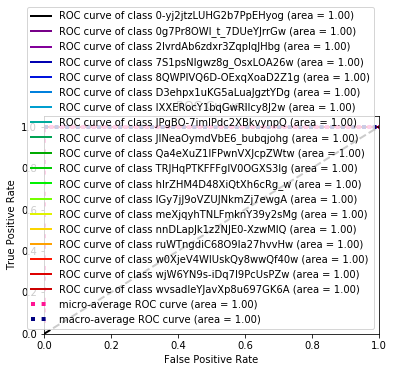

Training logistic regression on prediction problem 1


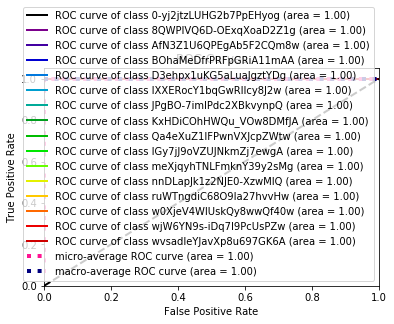

Training logistic regression on prediction problem 2


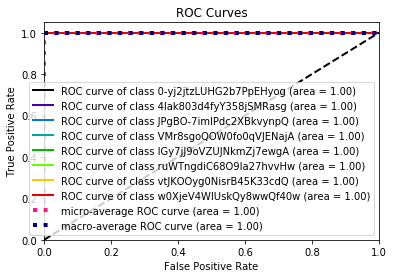

Training logistic regression on prediction problem 3


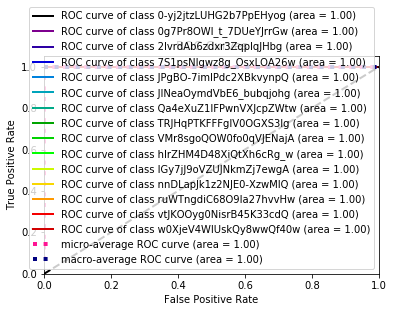

Training logistic regression on prediction problem 4


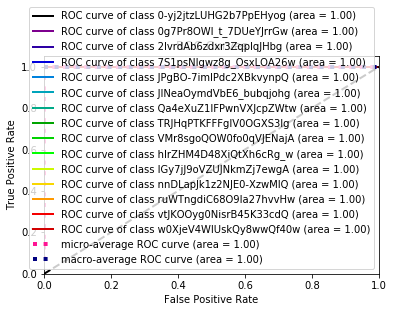

Training logistic regression on prediction problem 5


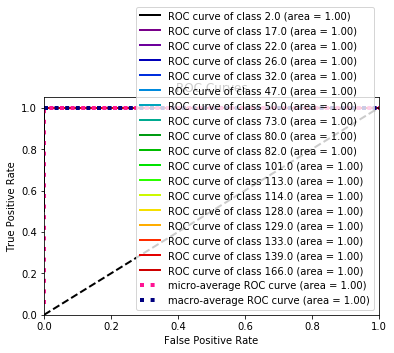

Training logistic regression on prediction problem 6


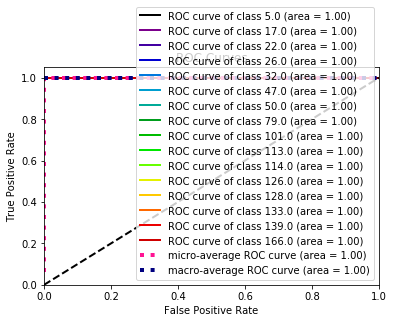

Training logistic regression on prediction problem 7


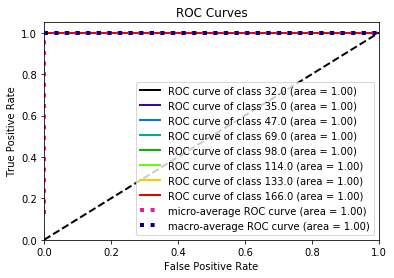

Training logistic regression on prediction problem 8


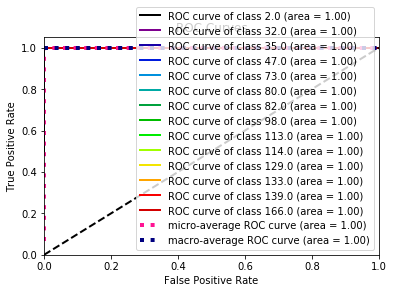

Training logistic regression on prediction problem 9


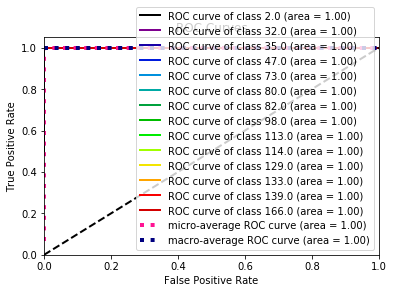

Training logistic regression on prediction problem 10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


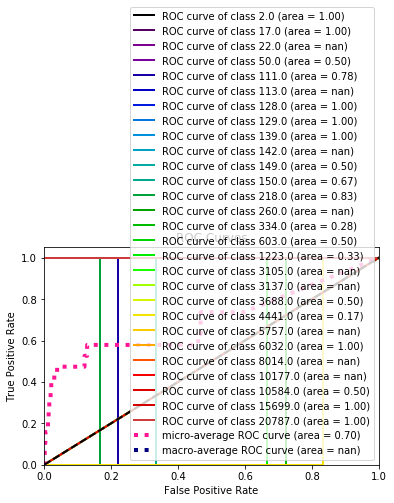

Training logistic regression on prediction problem 11


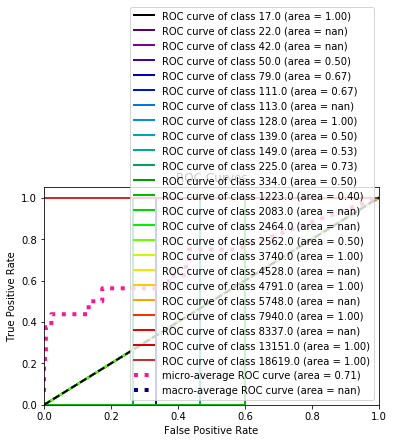

Training logistic regression on prediction problem 12


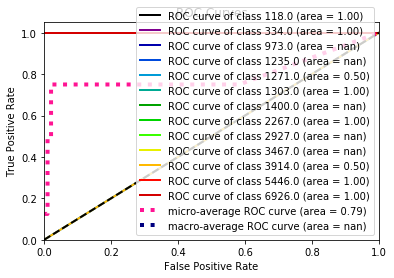

Training logistic regression on prediction problem 13


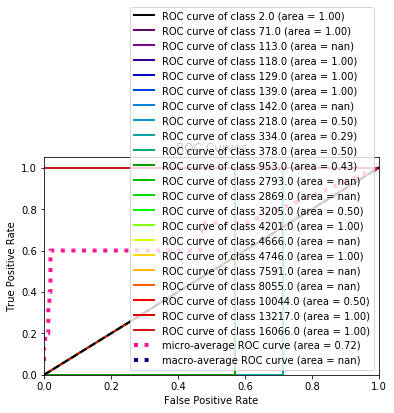

Training logistic regression on prediction problem 14


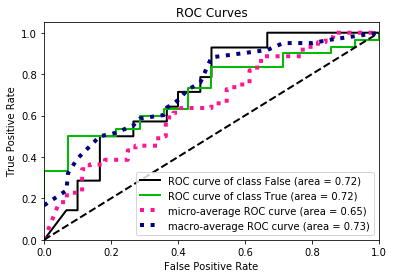

Training logistic regression on prediction problem 15


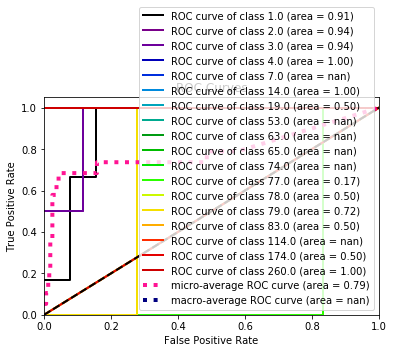

Training logistic regression on prediction problem 16


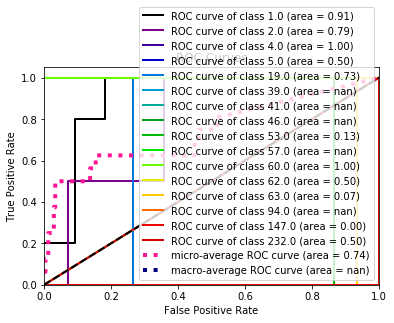

Training logistic regression on prediction problem 17


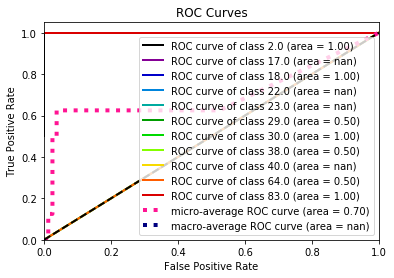

Training logistic regression on prediction problem 18


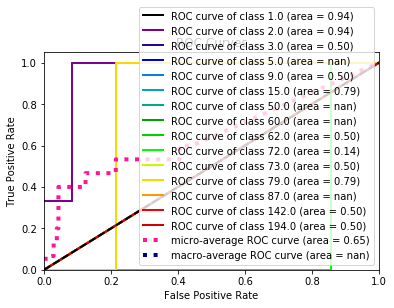

Training logistic regression on prediction problem 19


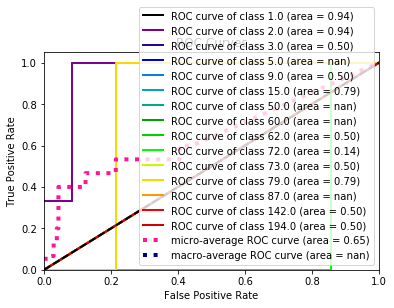

Training logistic regression on prediction problem 20


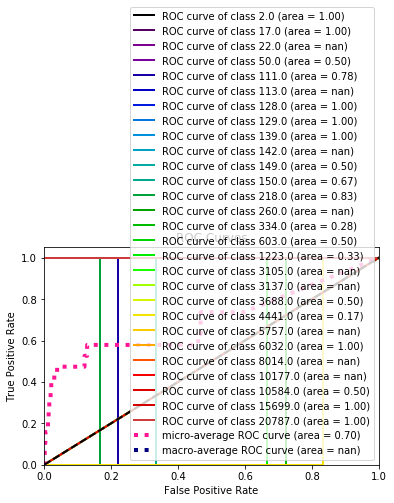

Training logistic regression on prediction problem 21


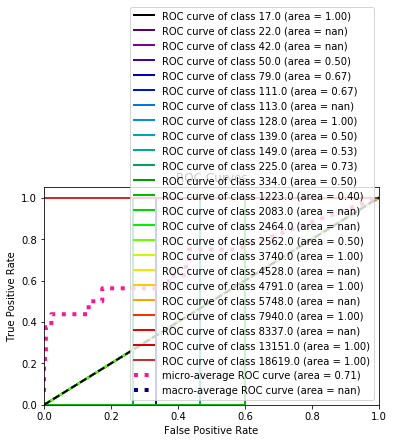

Training logistic regression on prediction problem 22


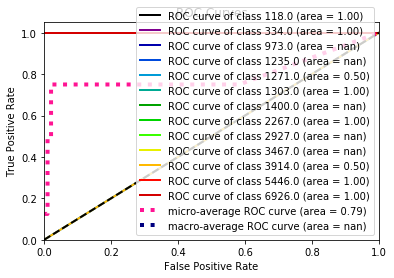

Training logistic regression on prediction problem 23


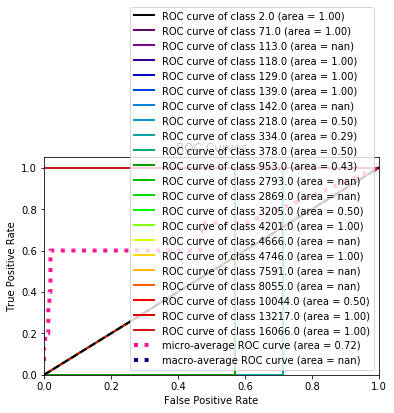

Training logistic regression on prediction problem 24


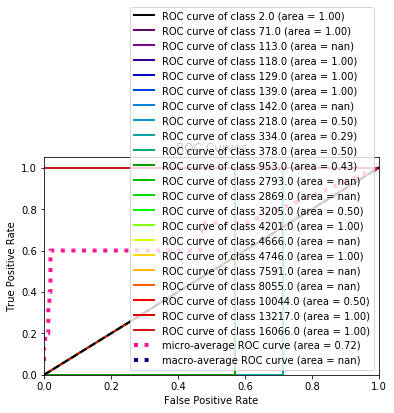

Training logistic regression on prediction problem 25


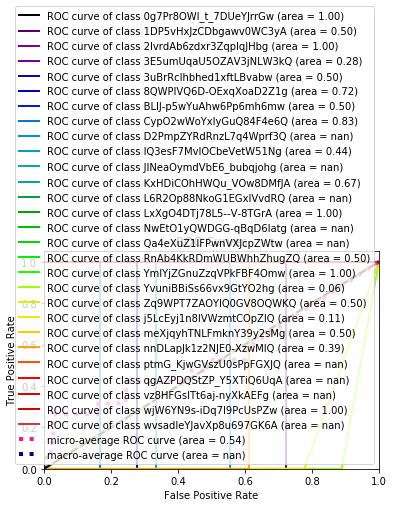

Training logistic regression on prediction problem 26


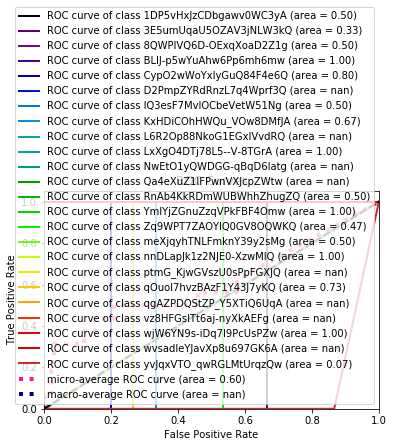

Training logistic regression on prediction problem 27


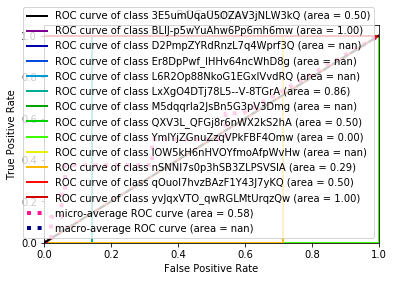

Training logistic regression on prediction problem 28


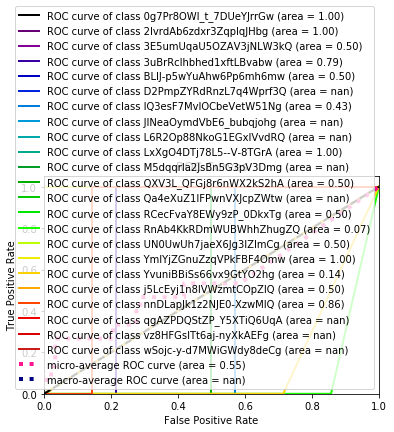

Training logistic regression on prediction problem 29


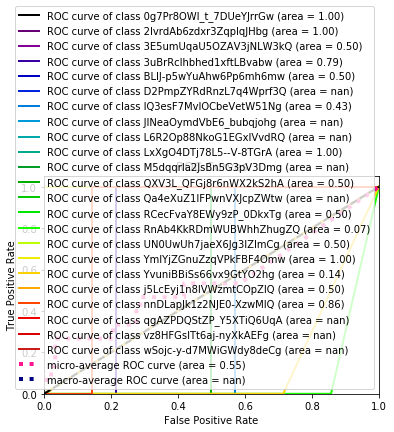

Training logistic regression on prediction problem 30


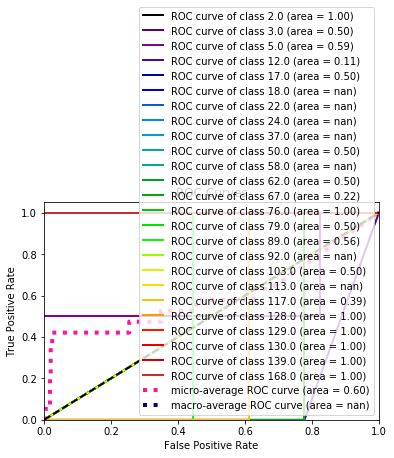

Training logistic regression on prediction problem 31


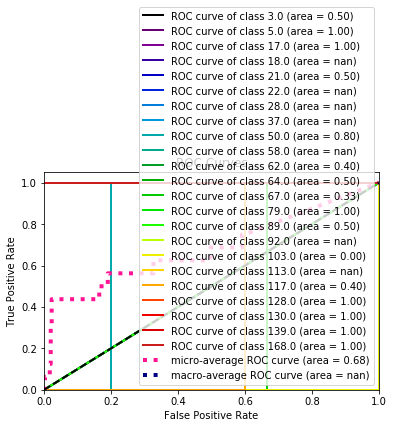

Training logistic regression on prediction problem 32


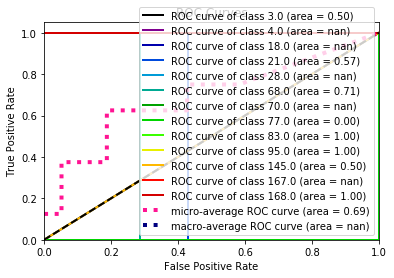

Training logistic regression on prediction problem 33


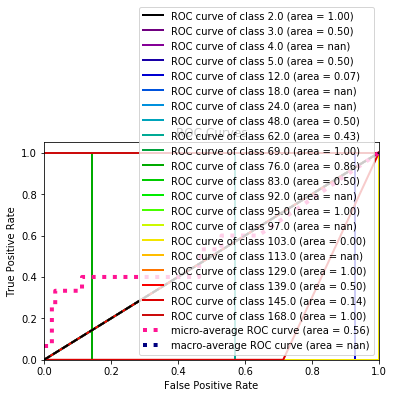

Training logistic regression on prediction problem 34


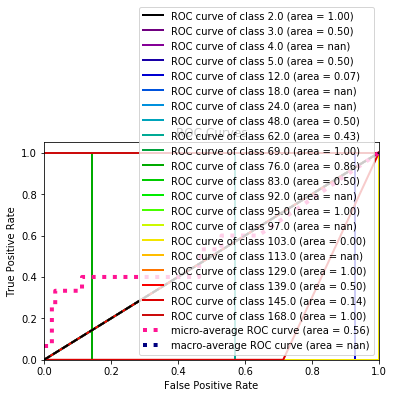

Training logistic regression on prediction problem 35


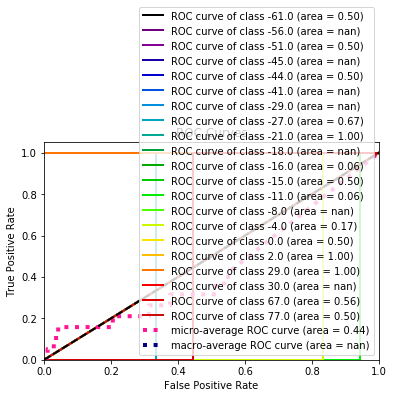

Training logistic regression on prediction problem 36


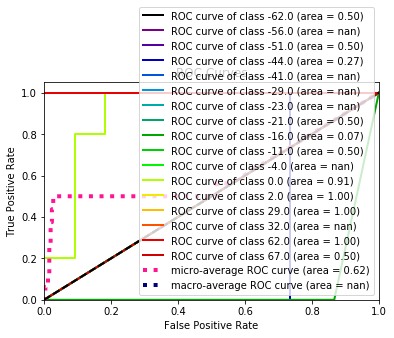

Training logistic regression on prediction problem 37


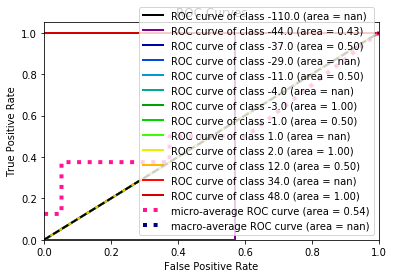

Training logistic regression on prediction problem 38


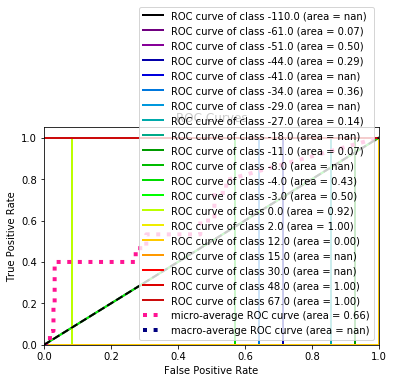

Training logistic regression on prediction problem 39


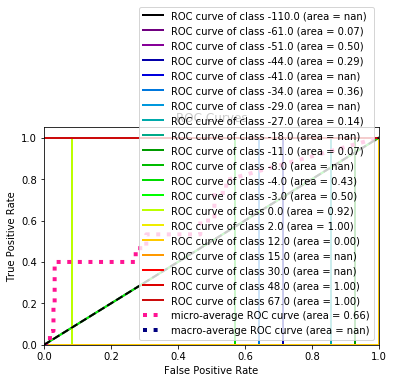

In [19]:
logistic = linear_model.LogisticRegression()

PROBLEM_IDX_WITH_OOB_ERROR = 14
# PROBLEM_IDX_WITH_NO_ERROR = 13

# idx = PROBLEM_IDX_WITH_NO_ERROR
# label = labels[idx]
# print("Training logistic regression on prediction problem {}".format(idx))
# label = label.dropna()
# training_features = training_features_matrix[training_features_matrix.index.isin(label.business_id)]
# training_labels = list(label['problem_label_excluding_data_post_label_cutoff_time'])

# test_features = test_features_matrix[test_features_matrix.index.isin(label.business_id)]
# test_labels = list(label['problem_label_all_data'])
# logistic.fit(training_features, training_labels)

# predicted_labels = logistic.predict(test_features)
# predicted_probabilities = logistic.predict_proba(test_features)
# try:
#     skplt.metrics.plot_roc_curve(test_labels, predicted_probabilities)
#     print("# of test labels: {}".format(len(test_labels)))
#     print("# of unique test labels: {}".format(len(np.unique(test_labels))))
#     print(predicted_probabilities.shape)
# except Exception as e:
#     print(e)
    
# idx = PROBLEM_IDX_WITH_OOB_ERROR
# label = labels[idx]
for idx, label in enumerate(labels):
    #Note: modifying the problem so it's a classification, not a regression, by using a GreaterRowOp with threshold:50.


    print("Training logistic regression on prediction problem {}".format(idx))
    label = label.dropna()
    training_features = training_features_matrix[training_features_matrix.index.isin(label[entity_id_column])]
    training_labels = list(label['problem_label_excluding_data_post_label_cutoff_time'])

    test_features = test_features_matrix[test_features_matrix.index.isin(label[entity_id_column])]
    test_labels = list(label['problem_label_all_data'])
    logistic.fit(training_features, training_labels)

    predicted_labels = logistic.predict(test_features)
    predicted_probabilities = logistic.predict_proba(test_features)

    indices = find_missing_label_indices(training_labels, test_labels)
    predicted_probabilities = format_predicted_proba(predicted_probabilities, indices)

    try:
        skplt.metrics.plot_roc_curve(
                                    test_labels, predicted_probabilities,
                                    classes = np.unique(training_labels + test_labels)
                                    )
    except Exception as e:
        print("# of test labels: {}".format(len(test_labels)))
        print("# of unique test labels: {}".format(len(np.unique(test_labels))))
        print(predicted_probabilities.shape)
        print("ERROR: {}".format(e))
    plt.show()


In [14]:
def find_missing_label_indices(train_labels, test_labels):
    """
    Finds the indices where columns of all zeros should be inserted to predicted_proba.
    
    Args
    ----------
    train_labels: the labels seen in training
    test_labels: the labels seen in testing
    
    Returns
    ----------
    indices_to_add: list of indices where a column should be inserted before each index
        to ensure all labels seen in test have a corresponding probability.
    """
    if set(test_labels).issubset(train_labels):
        return []
    train_classes = (np.unique(np.array(train_labels)))
    test_classes = (np.unique(np.array(test_labels)))
    values = np.setdiff1d(test_classes, train_classes)
    indices_to_add = [np.where(test_classes == value)[0][0] for value in values]
    return indices_to_add
def format_predicted_proba(array, indices):
    """
    Insert the columns of all zeros into array at indices
    
    Args
    ----------
    array: array to perform insertions on
    indices: the indices before which a column of zeros should be inserted
    
    Returns
    ----------
    array: updated array with columns of all zeros inserted
    """
    if indices is None:
        return array
    indices_before_len = [idx for idx in indices if idx <= array.shape[1]]
    partially_filled_array = np.insert(array, indices_before_len, 0, axis = 1)
    num_indices_after_len = len(indices) - len(indices_before_len)
    arr_to_append = np.zeros((array.shape[0], num_indices_after_len))
    return np.append(partially_filled_array, arr_to_append, axis = 1)

In [18]:
label

,business_id,problem_label_excluding_data_post_label_cutoff_time,problem_label_all_data,training_cutoff_time,label_cutoff_time
0,-A9sm-E6uQxWTJ_MuyOzFw,10.0,10,2012-01-01,2015-01-01
1,-Bdw-5H5C4AYSMGnAvmnzw,91.0,91,2012-01-01,2015-01-01
2,-BxWyEIQ6wypT-37MzZizQ,110.0,110,2012-01-01,2015-01-01
5,-Ucy8i4uc_OzN8y5fkGVaQ,96.0,96,2012-01-01,2015-01-01
6,-Y0HN99LWf43NYQAx0T5aQ,106.0,106,2012-01-01,2015-01-01
7,-cBQKodqi77Q0vk-9iDvQA,111.0,111,2012-01-01,2015-01-01
8,-dy1d0ohs4D8qkJoenHNJA,3.0,3,2012-01-01,2015-01-01
10,-hn7E7b3VwRjwhNEDgmGIQ,40.0,40,2012-01-01,2015-01-01
12,-jGA3ADqqv0PyB7Mbo-Zsw,56.0,56,2012-01-01,2015-01-01
13,-sAr-LA9TsIdl37UjwBlvg,147.0,147,2012-01-01,2015-01-01
